In [1]:
import sys
import cantera as ct
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.legend_handler import HandlerTuple

import phases
import feedstock as fs
import fuel as fu
import energy as en
import gasifier as gs

For species Fe(c), discontinuity in cp/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 4.2881898

For species Fe(c), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 3.425820683333331

For species Fe(c), discontinuity in s/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.0
	Value computed using high-temperature polynomial: 8.486560101557188

For species Cr(cr), discontinuity in cp/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  749.1520512400002
	Value computed using high-temperature polynomial: 0.0

For species Cr(cr), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  113.24055562733336
	Value computed using high-temperature polynomial: 0.0

For species Cr(cr), discontinuity in s/R detec

In [2]:
# Biomass characteristics as given by de Medeiros et al., 2017 - 10.1016/j.jclepro.2017.01.165
ultimate = [46.96, 5.72, 44.05, 0.27, 0.04, 0.02] # d.b.
ash = 2.94 / 100 # d.b.
moist = 50.00 / 100 # d.b.
HHV = 18.5 # MJ/kg, d.b.
fuel = fs.create_fuel_stream(1, ultimate, ash, moist, HHV)

In [3]:
stoichAir = fs.create_air_from_ER(fuel, 1.0)
stoichAirMass = stoichAir.get_mass()
stoichOxygen = fs.create_O2_from_ER(fuel, 1.0)
stoichOxygenMass = stoichOxygen.get_mass()

In [4]:
T0 = 298.15
P0 = ct.one_atm

ERs = np.arange(0.0, 1.0+1E-9, 0.01)
outs_by_ER = []

for i, er in enumerate(ERs):
    air = fs.create_air_from_ER(fuel, er)
    outlet = gs.gasify_nonisot(fuel, air, T0=T0, P=P0, heatLossFraction=0, charFormation=0, directMethaneConv=0)
    outs_by_ER.append(outlet)

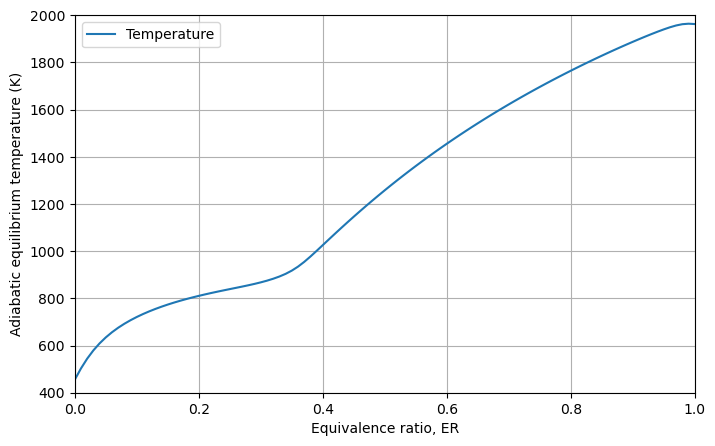

In [5]:
fig1 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(ERs, [out.T for out in outs_by_ER], label='Temperature')
plt.legend(loc='best')
plt.xlabel('Equivalence ratio, ER')
plt.ylabel('Adiabatic equilibrium temperature (K)')
plt.xlim(ERs[0], ERs[-1])
plt.ylim(400, 2000)
plt.grid()
plt.savefig('figures/sensit_Temp_ER.png')
plt.show()

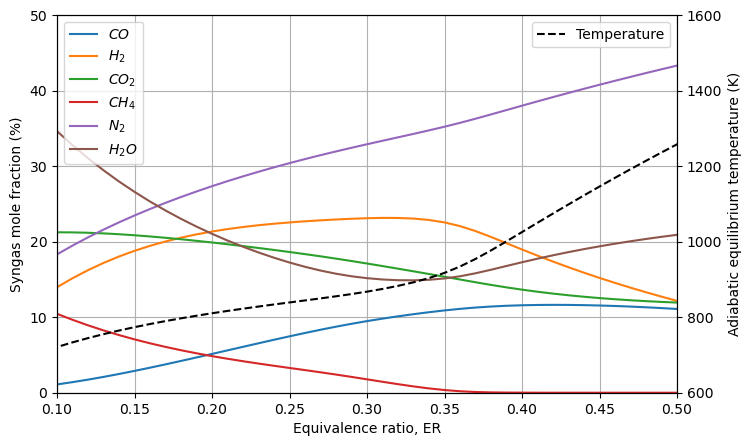

In [39]:
fig2, ax2a = plt.subplots(figsize=(8,5), dpi=100)
ax2a.plot(ERs, [100*out.get_syngas_fraction('CO', water=True, nitrogen=True) for out in outs_by_ER], label='$CO$')
ax2a.plot(ERs, [100*out.get_syngas_fraction('H2', water=True, nitrogen=True) for out in outs_by_ER], label='$H_2$')
ax2a.plot(ERs, [100*out.get_syngas_fraction('CO2', water=True, nitrogen=True) for out in outs_by_ER], label='$CO_2$')
ax2a.plot(ERs, [100*out.get_syngas_fraction('CH4', water=True, nitrogen=True) for out in outs_by_ER], label='$CH_4$')
ax2a.plot(ERs, [100*out.get_syngas_fraction('N2', water=True, nitrogen=True) for out in outs_by_ER], label='$N_2$')
ax2a.plot(ERs, [100*out.get_syngas_fraction('H2O', water=True, nitrogen=True) for out in outs_by_ER], label='$H_2O$')
# plt.plot(ERs, [100*(1 - out.species_moles[phases.indices['C(gr)']]/fuel.species_moles[phases.indices['C(gr)']]) for out in outs_by_ER], label='$CC$')
# plt.plot(ERs, [100*out.species_moles[phases.indices['C(gr)']]/sum(out.species_moles) for out in outs_by_ER], label='$C$')
ax2a.legend(loc='best')
ax2a.set_xlabel('Equivalence ratio, ER')
ax2a.set_ylabel('Syngas mole fraction (%)')
ax2a.set_xlim(0.1, 0.5)
ax2a.set_ylim(0, 50)
ax2b = ax2a.twinx()
ax2b.plot(ERs, [out.T for out in outs_by_ER], label='Temperature', linestyle='--', color='black')
ax2b.set_ylim(600, 1600)
ax2b.set_ylabel('Adiabatic equilibrium temperature (K)')
ax2b.legend(loc='best')
ax2a.grid()
plt.savefig('figures/sensit_Compos_ER.png')
plt.show()

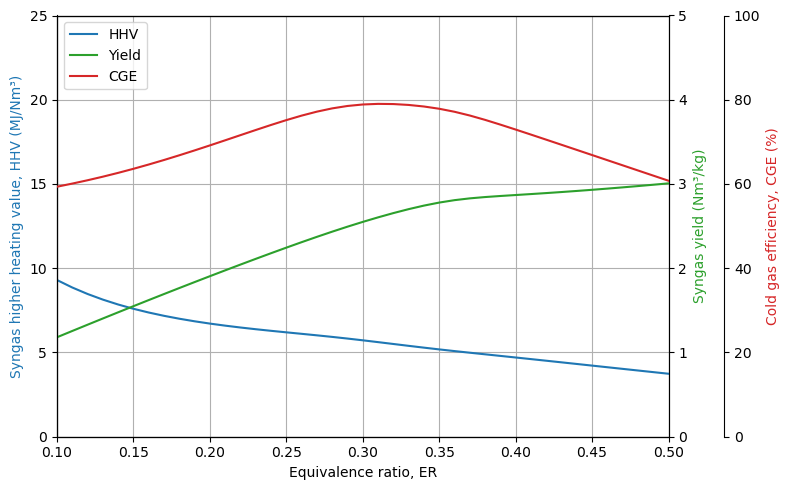

In [7]:
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig3, host = plt.subplots(figsize=(8,5), dpi=100) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0.1, 0.5)
host.set_ylim(0, 25)
par1.set_ylim(0, 5)
par2.set_ylim(0, 100)
    
host.set_xlabel("Equivalence ratio, ER")
host.set_ylabel("Syngas higher heating value, HHV (MJ/Nm³)")
par1.set_ylabel("Syngas yield (Nm³/kg)")
par2.set_ylabel("Cold gas efficiency, CGE (%)")

colors = ['tab:blue', 'tab:green', 'tab:red']

p1, = host.plot(ERs, [out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outs_by_ER], color=colors[0], label="HHV", zorder=3)
p2, = par1.plot(ERs, [out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outs_by_ER], color=colors[1], label="Yield", zorder=3)
p3, = par2.plot(ERs, [100*out.get_syngas_CGE() for out in outs_by_ER], color=colors[2], label="CGE", zorder=3)

lns = [p1, p2, p3]
host.legend(handles=lns, loc='upper left')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 40))

# no x-ticks         
# par2.xaxis.set_ticks([])

# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')

# Move "Velocity"-axis to the left
# par2.spines['left'].set_position(('outward', 60))
# par2.spines['left'].set_visible(True)
# par2.yaxis.set_label_position('left')
# par2.yaxis.set_ticks_position('left')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Adjust spacings w.r.t. figsize
fig3.tight_layout()
# Alternatively: bbox_inches='tight' within the plt.savefig function 
#                (overwrites figsize)

# Best for professional typesetting, e.g. LaTeX
# plt.savefig("pyplot_multiple_y-axis.pdf")
host.grid(zorder=-1, axis='both')
plt.savefig('figures/sensit_Eff_ER.png')
plt.show()
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'

In [8]:
optAir = fs.create_air_from_ER(fuel, 0.3)

In [9]:
Ps = np.arange(0.1, 20+1E-9, 0.1) * ct.one_atm
outs_by_P = []

for i, p in enumerate(Ps):
    outlet = gs.gasify_nonisot(fuel, optAir, T0=T0, P=p, heatLossFraction=0, charFormation=0, directMethaneConv=0)
    outs_by_P.append(outlet)

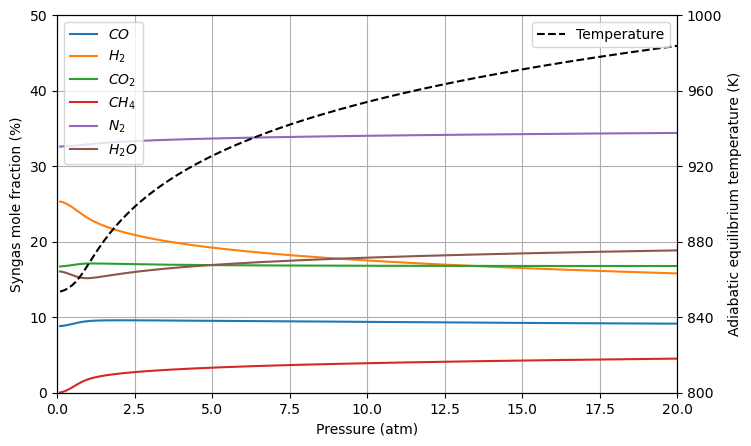

In [38]:
fig4, ax4a = plt.subplots(figsize=(8,5), dpi=100)
ax4a.plot(Ps/ct.one_atm, [100*out.get_syngas_fraction('CO', water=True, nitrogen=True) for out in outs_by_P], label='$CO$')
ax4a.plot(Ps/ct.one_atm, [100*out.get_syngas_fraction('H2', water=True, nitrogen=True) for out in outs_by_P], label='$H_2$')
ax4a.plot(Ps/ct.one_atm, [100*out.get_syngas_fraction('CO2', water=True, nitrogen=True) for out in outs_by_P], label='$CO_2$')
ax4a.plot(Ps/ct.one_atm, [100*out.get_syngas_fraction('CH4', water=True, nitrogen=True) for out in outs_by_P], label='$CH_4$')
ax4a.plot(Ps/ct.one_atm, [100*out.get_syngas_fraction('N2', water=True, nitrogen=True) for out in outs_by_P], label='$N_2$')
ax4a.plot(Ps/ct.one_atm, [100*out.get_syngas_fraction('H2O', water=True, nitrogen=True) for out in outs_by_P], label='$H_2O$')
ax4a.set_xlim(0, Ps[-1]/ct.one_atm)
ax4a.legend(loc='upper left')
ax4a.set_xlabel('Pressure (atm)')
ax4a.set_ylabel('Syngas mole fraction (%)')
ax4a.set_ylim(0, 50)
ax4a.set_xticks(np.arange(0, Ps[-1]/ct.one_atm + 1e-2, 2.5))
ax4b = ax4a.twinx()
ax4a.grid()
ax4b.plot(Ps/ct.one_atm, [out.T for out in outs_by_P], label='Temperature', linestyle='--', color='black')
ax4b.set_ylim(800, 1000)
ax4b.set_ylabel('Adiabatic equilibrium temperature (K)')
ax4b.legend(loc='upper right')
ax4b.set_yticks(np.arange(800, 1000+1e-2, 40))
plt.savefig('figures/sensit_Compos_P.png')
plt.show()

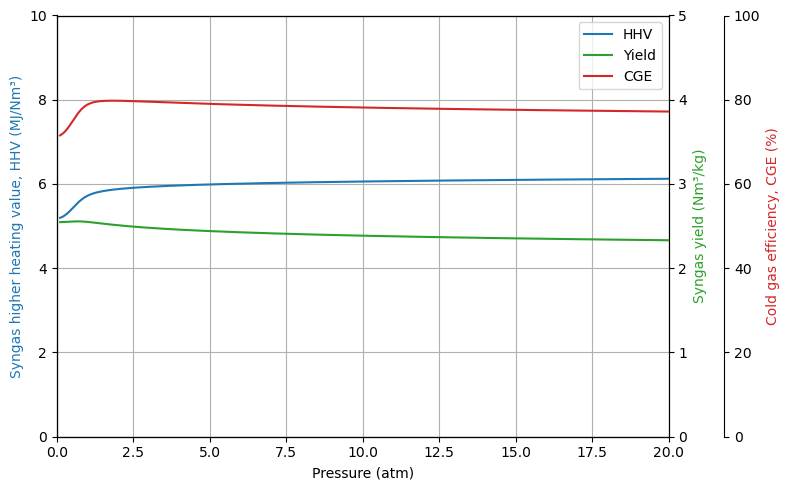

In [11]:
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig5, host = plt.subplots(figsize=(8,5), dpi=100) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 20)
host.set_ylim(0, 10)
par1.set_ylim(0, 5)
par2.set_ylim(0, 100)

host.set_xlabel("Pressure (atm)")
host.set_ylabel("Syngas higher heating value, HHV (MJ/Nm³)")
par1.set_ylabel("Syngas yield (Nm³/kg)")
par2.set_ylabel("Cold gas efficiency, CGE (%)")

colors = ['tab:blue', 'tab:green', 'tab:red']

p1, = host.plot(Ps/ct.one_atm, [out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outs_by_P], color=colors[0], label="HHV", zorder=3)
p2, = par1.plot(Ps/ct.one_atm, [out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outs_by_P], color=colors[1], label="Yield", zorder=3)
p3, = par2.plot(Ps/ct.one_atm, [100*out.get_syngas_CGE() for out in outs_by_P], color=colors[2], label="CGE", zorder=3)

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 40))

# no x-ticks         
# par2.xaxis.set_ticks([])

# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')

# Move "Velocity"-axis to the left
# par2.spines['left'].set_position(('outward', 60))
# par2.spines['left'].set_visible(True)
# par2.yaxis.set_label_position('left')
# par2.yaxis.set_ticks_position('left')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Adjust spacings w.r.t. figsize
fig5.tight_layout()
# Alternatively: bbox_inches='tight' within the plt.savefig function 
#                (overwrites figsize)

# Best for professional typesetting, e.g. LaTeX
# plt.savefig("pyplot_multiple_y-axis.pdf")
host.grid(zorder=-1, axis='both')
plt.savefig('figures/sensit_Eff_P.png')
plt.show()
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'

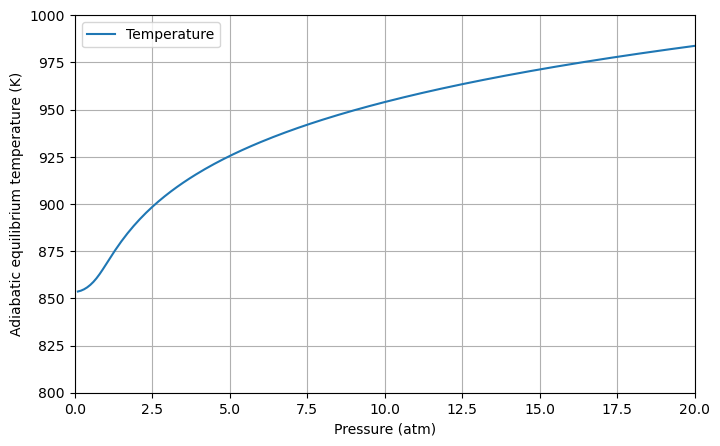

In [12]:
fig6 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(Ps/ct.one_atm, [out.T for out in outs_by_P], label='Temperature')
plt.legend(loc='best')
plt.xlabel('Pressure (atm)')
plt.ylabel('Adiabatic equilibrium temperature (K)')
plt.xlim(0, Ps[-1]/ct.one_atm)
plt.ylim(800, 1000)
plt.grid()
plt.savefig('figures/sensit_Temp_P.png')
plt.show()

In [13]:
moists = np.arange(0, 100+1e-9, 1) / 100
outs_by_moist = []

for i, m in enumerate(moists):
    fuel.set_moisture(m)
    outlet = gs.gasify_nonisot(fuel, optAir, T0=T0, P=P0, heatLossFraction=0, charFormation=0, directMethaneConv=0)
    outs_by_moist.append(outlet)

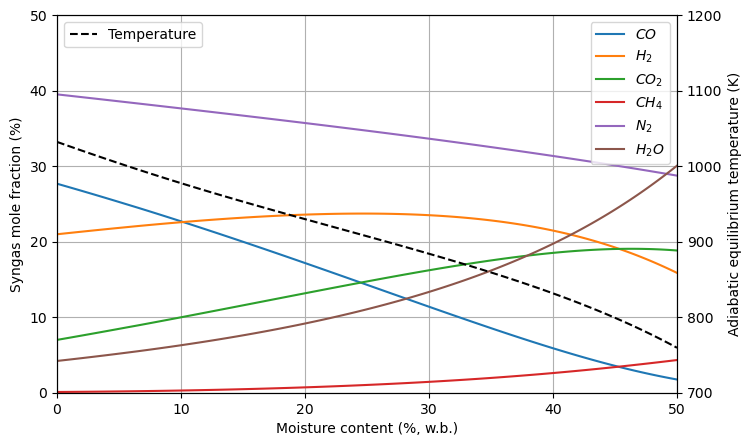

In [45]:
fig7, ax7a = plt.subplots(figsize=(8,5), dpi=100)
moistsWB = moists / (1 + moists)

ax7a.plot(100*moistsWB, [100*out.get_syngas_fraction('CO', water=True, nitrogen=True) for out in outs_by_moist], label='$CO$')
ax7a.plot(100*moistsWB, [100*out.get_syngas_fraction('H2', water=True, nitrogen=True) for out in outs_by_moist], label='$H_2$')
ax7a.plot(100*moistsWB, [100*out.get_syngas_fraction('CO2', water=True, nitrogen=True) for out in outs_by_moist], label='$CO_2$')
ax7a.plot(100*moistsWB, [100*out.get_syngas_fraction('CH4', water=True, nitrogen=True) for out in outs_by_moist], label='$CH_4$')
ax7a.plot(100*moistsWB, [100*out.get_syngas_fraction('N2', water=True, nitrogen=True) for out in outs_by_moist], label='$N_2$')
ax7a.plot(100*moistsWB, [100*out.get_syngas_fraction('H2O', water=True, nitrogen=True) for out in outs_by_moist], label='$H_2O$')
ax7a.set_xlim(100*moistsWB[0], 100*moistsWB[-1])
ax7a.legend(loc='upper right')
ax7a.set_xlabel('Moisture content (%, w.b.)')
ax7a.set_ylabel('Syngas mole fraction (%)')
ax7a.set_xlim(100*moistsWB[0], 100*moistsWB[-1])
ax7a.set_ylim(0, 50)
ax7b = ax7a.twinx()
ax7b.plot(moistsWB*100, [out.T for out in outs_by_moist], label='Temperature', linestyle='--', color='black')
ax7b.set_ylim(700, 1200)
ax7b.set_ylabel('Adiabatic equilibrium temperature (K)')
ax7b.legend(loc='upper left')
ax7b.set_yticks(np.arange(700, 1200+1e-2, 100))
ax7a.grid()
plt.savefig('figures/sensit_Compos_Moist.png')
plt.show()

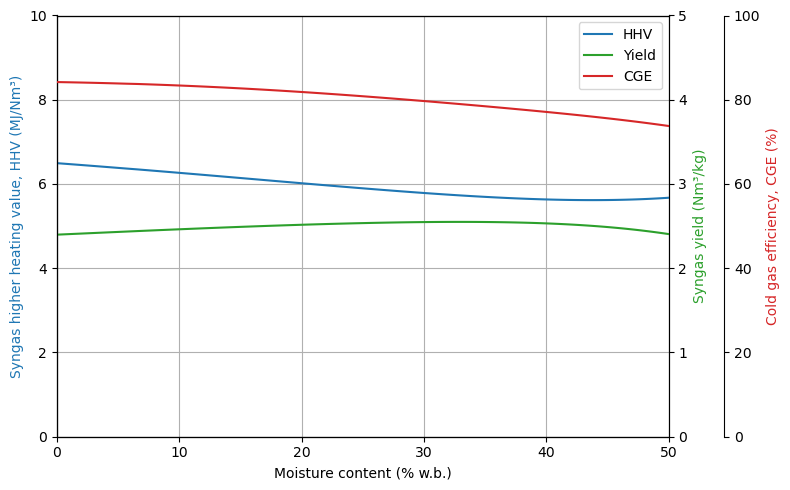

In [15]:
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig8, host = plt.subplots(figsize=(8,5), dpi=100) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 50)
host.set_ylim(0, 10)
par1.set_ylim(0, 5)
par2.set_ylim(0, 100)
    
host.set_xlabel("Moisture content (% w.b.)")
host.set_ylabel("Syngas higher heating value, HHV (MJ/Nm³)")
par1.set_ylabel("Syngas yield (Nm³/kg)")
par2.set_ylabel("Cold gas efficiency, CGE (%)")

colors = ['tab:blue', 'tab:green', 'tab:red']

p1, = host.plot(100*moistsWB, [out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outs_by_moist], color=colors[0], label="HHV", zorder=3)
p2, = par1.plot(100*moistsWB, [out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outs_by_moist], color=colors[1], label="Yield", zorder=3)
p3, = par2.plot(100*moistsWB, [100*out.get_syngas_CGE() for out in outs_by_moist], color=colors[2], label="CGE", zorder=3)

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 40))

# no x-ticks         
# par2.xaxis.set_ticks([])

# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')

# Move "Velocity"-axis to the left
# par2.spines['left'].set_position(('outward', 60))
# par2.spines['left'].set_visible(True)
# par2.yaxis.set_label_position('left')
# par2.yaxis.set_ticks_position('left')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Adjust spacings w.r.t. figsize
fig8.tight_layout()
# Alternatively: bbox_inches='tight' within the plt.savefig function 
#                (overwrites figsize)

# Best for professional typesetting, e.g. LaTeX
# plt.savefig("pyplot_multiple_y-axis.pdf")
host.grid(zorder=-1, axis='both')
plt.savefig('figures/sensit_Eff_Moist.png')
plt.show()
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'

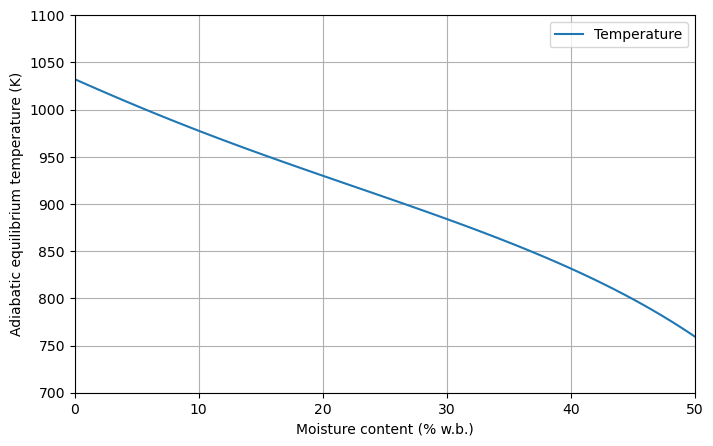

In [16]:
fig9 = plt.figure(figsize=(8,5), dpi=100)
plt.plot(moistsWB*100, [out.T for out in outs_by_moist], label='Temperature')
plt.legend(loc='best')
plt.xlabel('Moisture content (% w.b.)')
plt.ylabel('Adiabatic equilibrium temperature (K)')
plt.xlim(moistsWB[0]*100, moistsWB[-1]*100)
plt.ylim(700, 1100)
plt.grid()
plt.savefig('figures/sensit_Temp_Moist.png')
plt.show()